# Figures for Slides

In [7]:
import os, sys, importlib
import pandas as pd
import numpy as np
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '/home/jovyan/a01_repos')
# import wx_tools.Wx_Utils as utl
# importlib.reload(sys.modules['Wx_Utils'])

sys.path.insert(0, '/home/jovyan/a01_repos/joe_utils')
# import joe_utils.UDF_Visualisation as viz

# Project specific user-defined functions
# import utl_scr_opt as udf
# importlib.reload(sys.modules['utl_scr_opt'])

import utl_ipop as utl

sns.set_palette(sns.color_palette("muted", 10))

In [8]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Prep

In [9]:
# Load data
scored_base = pd.read_parquet('data/decision_model_base_999.parquet')

# Initial best offers
scored_best = pd.read_parquet('data/decision_model_999.parquet')

# Analysis without missing crns
# Missing crns in best offer were assigned to random group
crn_missing = list(set(scored_base['crn']) - set(scored_best['crn']))
cond = scored_base['crn'].isin(crn_missing)

# Analysis without missing crn
scored_base = scored_base[~cond]
scored_base.shape
scored_base['crn'].nunique()
scored_best['crn'].nunique()

(279114, 27)

5044

5044

In [269]:
# lb=[-2]; ub=[1, 1]
lb=[-2]; ub=[2,2]
# lb=[-2]; ub=[5,5]

t_start = utl.Timer()
res = udf.ipop(scored_base, scored_best, lb=lb, ub=ub, verbose=True, i_max=1)
utl.Timer(t_start)

iter: 1, x_opt: 0.7283
>> IPOP reached user iteration limit: 1

>> Time taken: 0 hours 0 minutes and 0.89 seconds.


In [270]:
x = np.linspace(0.3, 2.5, 100)
y = -udf.obj_func(x, top2, best_metrics, scenario='opt')

best_profit = scored_best['inc_sales'].sum() - scored_best['target_cost'].sum()
y_perc = y / best_profit * 100

In [271]:
base = scored_base.copy()
best = scored_best.copy()

# Top 2 offers: prep for obj_func
score = 'inc_sales'
sort_cols   = ['crn', score, 'target_cost', 'score']
sort_dir    = [True, False, True, False]
constr_cols = ['p_rdm', 'p_open', 'p_unsub']
metric_cols = ['inc_sales', 'target_cost', 'profit']

base.sort_values(by=sort_cols, ascending=sort_dir, inplace=True)
base['rank'] = base.groupby('crn')[sort_cols[1]].rank(ascending=sort_dir[1], method='first').astype('uint8')
base['is_best'] = np.where(base['rank'] == 1, 1, 0)
base['is_best_2nd'] = np.where(base['rank'] == 2, 1, 0)

# Top 2 offers
cond = (base['is_best'] == 1) | (base['is_best_2nd'] == 1)
top2 = base[cond]

# Top 2 diff for SC gradient
top2_diff = top2[metric_cols[:2]] - top2.groupby('crn')[metric_cols[:2]].shift() 
top2 = top2.merge(top2_diff, left_index=True, right_index=True, suffixes=('', '_diff'))
top2['scr_gradient'] = top2['inc_sales_diff'] / top2['target_cost_diff']

# Current best offer metrics
best_metrics = best[metric_cols[:2]].sum()
best_metrics['profit'] = best_metrics[0] - best_metrics[1]

base_constr_metrics = best[constr_cols].sum()

In [272]:
# Constraints
con = udf.constr_ineq(x, top2, base_constr_metrics, lb=lb, ub=ub)
con = con.reshape(3,-1)
con_rdm = ub[0] - con[0,:]
con_open = ub[1] - con[1,:]
con_unsub = lb[0] + con[2,:]

# Contraints at optimal x
con_opt = udf.constr_ineq(res.x_opt, top2, base_constr_metrics, lb=lb, ub=ub)
con_opt_rdm = ub[0] - con_opt[0]
con_opt_open = ub[1] - con_opt[1]
con_opt_unsub = lb[0] + con_opt[2]

## Visualise

In [268]:
con_rdm.max()

3.2344837

In [228]:
InteractiveShell.ast_node_interactivity = "last"

In [246]:
import utl_scr_opt as udf
importlib.reload(sys.modules['utl_scr_opt'])

<module 'utl_scr_opt' from '/home/jovyan/a02_projects/a06_scr_optimisation/utl_scr_opt.py'>

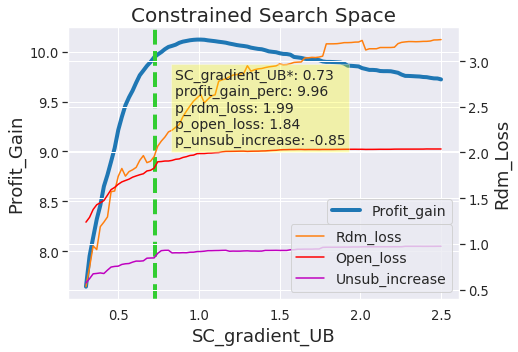

In [284]:
df_plot = pd.DataFrame(np.vstack((x, y_perc, con_rdm)).T, columns=['SC_gradient_UB', 'Profit_Gain', 'Rdm_Loss'])
x_opt = res.x_opt

# profit gain perc
y_opt = pd.DataFrame(res.rpt).iloc[0,5:6]
y_opt['p_rdm_loss'] = con_opt_rdm
y_opt['p_open_loss'] = con_opt_open
y_opt['p_unsub_increase'] = -con_opt_unsub

fig, ax, ax2 = udf.plot_dual_metrics(df_plot, x='SC_gradient_UB', y1='Profit_Gain', y2='Rdm_Loss', 
                                     line_x0=False,
                                     x_opt=x_opt, y_opt=y_opt,
                                     title='Constrained Search Space')

fig.set_size_inches(7, 5)
plt.setp(ax.lines,linewidth=4)

ax2.plot(x, con_open, 'r-', label='Open_loss')
ax2.plot(x, con_unsub, 'm-', label='Unsub_increase')
ax.legend(loc='lower right', bbox_to_anchor=(1, 0.25))
ax2.legend(loc='lower right')
plt.show()

## Constrained optimisation problem

$$
\begin{aligned}
\max_{x}       & \hspace{5mm} \text{profit-gain}(x) \\
\text{subject to } & \hspace{5mm} p_{rdm} \le ub_1, \\
                   & \hspace{5mm} p_{open} \le ub_2, \\
                   & \hspace{5mm} p_{unsub} \le ub_3
\end{aligned}
$$

## Distribution of rank of selected offers

### Constrained model

In [289]:
lb=[-2]; ub=[3,3]

t_start = utl.Timer()
res = udf.ipop(scored_base, scored_best, lb=lb, ub=ub, verbose=True)
utl.Timer(t_start)

iter: 1, x_opt: 1.0039
iter: 2, x_opt: 0.226
iter: 3, x_opt: 0.0
>> IPOP successful at iteration: 3

>> Time taken: 0 hours 0 minutes and 1.95 seconds.


In [298]:
res.base.groupby('rank_best')['crn'].nunique().to_frame()

crn
rank_best      
1          2945
2          1887
3           212

In [299]:
# Unconstrained
lb=[-np.inf]; ub=[np.inf, np.inf]

t_start = utl.Timer()
res = udf.ipop(scored_base, scored_best, lb=lb, ub=ub, verbose=True)
utl.Timer(t_start)

iter: 1, x_opt: 1.0039
iter: 2, x_opt: 1.0
iter: 3, x_opt: 0.9922
iter: 4, x_opt: 1.0
iter: 5, x_opt: 1.0
iter: 6, x_opt: 1.0
iter: 7, x_opt: 0.5
iter: 8, x_opt: 0.5
iter: 9, x_opt: 0.5
iter: 10, x_opt: 0.5
iter: 11, x_opt: 0.5
>> IPOP successful at iteration: 11

>> Time taken: 0 hours 0 minutes and 6.07 seconds.


In [301]:
res.base.groupby('rank_best')['crn'].nunique().to_frame().reset_index()

rank_best   crn
0          1  2945
1          2  1401
2          3   530
3          4   103
4          5    38
5          6    10
6          7     5
7          8     5
8          9     6
9         11     1